# **Point Net - Classification**

In this notebook, we will use the classification version of point net to classify objects from the shapenet dataset

In [1]:
import os
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3

from open3d.web_visualizer import draw # for non Colab

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
# TEMP for supressing pytorch user warnings
import warnings
warnings.filterwarnings("ignore")

In Colab you can run this cell to download the dataset. If you would like to download the dataset to your PC visit the url and the dataset will automatically download as a zip 

WARNING: Downloading the dataset will take a long time

In [3]:
# Run this only if you don't already have the Dataset
# !wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
# !unzip shapenetcore_partanno_segmentation_benchmark_v0.zip
# !rm shapenetcore_partanno_segmentation_benchmark_v0.zip

### Get the data

In [4]:
# General parameters
NUM_TRAIN_POINTS = 2500
NUM_TEST_POINTS = 10000
NUM_CLASSES = 16
ROOT = r'C:\Users\itber\Documents\datasets\shapenetcore_partanno_segmentation_benchmark_v0'

# model hyperparameters
GLOBAL_FEATS = 1024

BATCH_SIZE = 32

Helpers for our dataset

In [5]:
# get class - label mappings
CATEGORIES = {
    'Airplane': 0, 
    'Bag': 1, 
    'Cap': 2, 
    'Car': 3,
    'Chair': 4, 
    'Earphone': 5, 
    'Guitar': 6, 
    'Knife': 7, 
    'Lamp': 8, 
    'Laptop': 9,
    'Motorbike': 10, 
    'Mug': 11, 
    'Pistol': 12, 
    'Rocket': 13, 
    'Skateboard': 14, 
    'Table': 15}
            
# Simple point cloud coloring mapping for part segmentation
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [255, 0, 0],
        4: [255, 0, 255],  # purple
        5: [0, 255, 255],  # cyan
        6: [255, 255, 0],  # yellow
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

In [6]:
from torch.utils.data import DataLoader
from shapenet_dataset import ShapenetDataset

# train Dataset & DataLoader
train_dataset = ShapenetDataset(ROOT, npoints=NUM_TRAIN_POINTS, split='train', classification=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Validation Dataset & DataLoader
valid_dataset = ShapenetDataset(ROOT, npoints=NUM_TRAIN_POINTS, split='valid', classification=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

# test Dataset & DataLoader 
test_dataset = ShapenetDataset(ROOT, npoints=NUM_TEST_POINTS, split='test', classification=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# test Dataset  (segmentation version for display)
test_sample_dataset = ShapenetDataset(ROOT, npoints=NUM_TEST_POINTS, split='test', 
                                      classification=False, normalize=False)

### Explore the training data

In [8]:
sample_dataset = ShapenetDataset(ROOT, npoints=20000, split='train', 
                                 classification=False, normalize=False)

In [ ]:
points, seg = sample_dataset[4000]

pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(points)
pcd.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

o3.visualization.draw_plotly([pcd])

# optional visualization for non Colab
# draw(pcd)

Explore class frequencies and plot barchart

In [7]:
total_train_targets = []
for (_, targets) in train_dataloader:
    total_train_targets += targets.reshape(-1).numpy().tolist()

total_train_targets = np.array(total_train_targets)

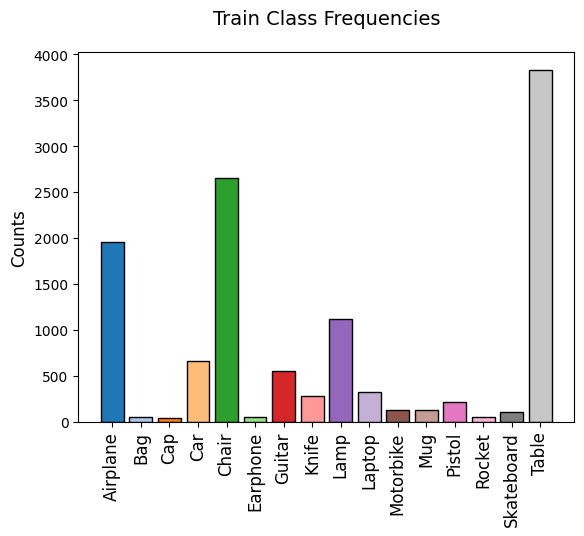

In [8]:
class_bins = np.bincount(total_train_targets)

plt.bar(list(CATEGORIES.keys()), class_bins, 
             color=mpl.cm.tab20(np.arange(0, NUM_CLASSES)),
             edgecolor='black')
plt.xticks(list(CATEGORIES.keys()), list(CATEGORIES.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Train Class Frequencies', size=14, pad=20);

In [23]:
from point_net import PointNetClassHead

points, targets = next(iter(train_dataloader))

classifier = PointNetClassHead(k=NUM_CLASSES, num_global_feats=GLOBAL_FEATS)
out, _, _ = classifier(points.transpose(2, 1))
print(f'Class output shape: {out.shape}')

Class output shape: torch.Size([32, 16])


Get DEVICE

In [24]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

### Define Loss for PointNet

For Point Net we will use the Categorical Cross Entropy loss with a regularization term that will enforce the high dimensional transform matrix to 0. We will also present the option for using the Balanced Cross Entropy loss via the 'alpha' argument which assigns a weight to each class this weights the importance of each example based on their class frequencies. We also provide the option to use the Focal loss which adds a modulating term to the Cross Entropy Loss $(1 - p_n)^\gamma$, this term forces the model to focus on hard examples (i.e. examples with low prediction probability).

In [25]:
import torch.optim as optim
from point_net_loss import PointNetLoss

EPOCHS = 50
LR = 0.0001
REG_WEIGHT = 0.001 

# use inverse class weighting
# alpha = 1 / class_bins
# alpha = (alpha/alpha.max())

# manually downweight the high frequency classes
alpha = np.ones(NUM_CLASSES)
alpha[0] = 0.5  # airplane
alpha[4] = 0.5  # chair
alpha[-1] = 0.5 # table

gamma = 1

optimizer = optim.Adam(classifier.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, 
                                              step_size_up=2000, cycle_momentum=False)
criterion = PointNetLoss(alpha=alpha, gamma=gamma, reg_weight=REG_WEIGHT).to(DEVICE)

classifier = classifier.to(DEVICE)

We want to be sure we are not misclassifying or only focusing on easy or abundant examples. So we use the Matthews Correlation Coefficient to measure our models performance.

In [26]:
mcc_metric = MulticlassMatthewsCorrCoef(num_classes=NUM_CLASSES).to(DEVICE)

### Begin Training Model

First define a helper function to train, validate, and test

In [27]:
def train_test(classifier, dataloader, num_batch, epoch, split='train'):
    ''' Function to train or test the model '''
    _loss = []
    _accuracy = []
    _mcc = []

    # return total targets and predictions for test case only
    total_test_targets = []
    total_test_preds = [] 
    for i, (points, targets) in enumerate(dataloader, 0):

        points = points.transpose(2, 1).to(DEVICE)
        targets = targets.squeeze().to(DEVICE)
        
        # zero gradients
        optimizer.zero_grad()
        
        # get predicted class logits
        preds, _, A = classifier(points)

        # get loss and perform backprop
        loss = criterion(preds, targets, A) 

        if split == 'train':
            loss.backward()
            optimizer.step()
        
        # get class predictions
        pred_choice = torch.softmax(preds, dim=1).argmax(dim=1) 
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct.item()/float(BATCH_SIZE)
        mcc = mcc_metric(preds, targets)

        # update epoch loss and accuracy
        _loss.append(loss.item())
        _accuracy.append(accuracy)
        _mcc.append(mcc.item())

        # add to total targets/preds
        if split == 'test':
            total_test_targets += targets.reshape(-1).cpu().numpy().tolist()
            total_test_preds += pred_choice.reshape(-1).cpu().numpy().tolist()

        if i % 100 == 0:
            print(f'\t [{epoch}: {i}/{num_batch}] ' \
                  + f'{split} loss: {loss.item():.4f} ' \
                  + f'accuracy: {accuracy:.4f} mcc: {mcc:.4f}')
        
    epoch_loss = np.mean(_loss)
    epoch_accuracy = np.mean(_accuracy)
    epoch_mcc = np.mean(_mcc)

    print(f'Epoch: {epoch} - {split} Loss: {epoch_loss:.4f} ' \
          + f'- {split} Accuracy: {epoch_accuracy:.4f} ' \
          + f'- {split} MCC: {epoch_mcc:.4f}')

    if split == 'test':
        return epoch_loss, epoch_accuracy, epoch_mcc, total_test_targets, total_test_preds
    else: 
        return epoch_loss, epoch_accuracy, epoch_mcc

In [28]:
# stuff for training
num_train_batch = int(np.ceil(len(train_dataset)/BATCH_SIZE))
num_valid_batch = int(np.ceil(len(valid_dataset)/BATCH_SIZE))

# store best validation mcc above 0.
best_mcc = 0.

# lists to store metrics (loss, accuracy, mcc)
train_metrics = []
valid_metrics = []

# TRAIN ON EPOCHS
for epoch in range(1, EPOCHS + 1):

    ## train loop
    classifier = classifier.train()
    
    # train
    _train_metrics = train_test(classifier, train_dataloader, 
                                num_train_batch, epoch, 
                                split='train')
    train_metrics.append(_train_metrics)
        

    # pause to cool down
    time.sleep(4)

    ## validation loop
    with torch.no_grad():

        # place model in evaluation mode
        classifier = classifier.eval()

        # validate
        _valid_metrics = train_test(classifier, valid_dataloader, 
                                    num_valid_batch, epoch, 
                                    split='valid')
        valid_metrics.append(_valid_metrics)

        # pause to cool down
        time.sleep(4)

    # save model if necessary
    if valid_metrics[-1][-1] >= best_mcc:
        best_mcc = valid_metrics[-1][-1]
        torch.save(classifier.state_dict(), 'trained_models/cls_focal_clr/cls_model_%d.pth' % epoch)

	 [1: 0/380] train loss: 2.8309 accuracy: 0.0312 mcc: -0.0319
	 [1: 100/380] train loss: 2.2949 accuracy: 0.2812 mcc: 0.1214
	 [1: 200/380] train loss: 1.4879 accuracy: 0.5625 mcc: 0.4833
	 [1: 300/380] train loss: 1.0096 accuracy: 0.5625 mcc: 0.4278
Epoch: 1 - train Loss: 1.7638 - train Accuracy: 0.4262 - train MCC: 0.3178
	 [1: 0/59] valid loss: 0.5282 accuracy: 0.7188 mcc: 0.0000
Epoch: 1 - valid Loss: 1.0147 - valid Accuracy: 0.6573 - valid MCC: 0.0291
	 [2: 0/380] train loss: 1.4553 accuracy: 0.5000 mcc: 0.4156
	 [2: 100/380] train loss: 0.7931 accuracy: 0.6562 mcc: 0.5896
	 [2: 200/380] train loss: 0.9963 accuracy: 0.5938 mcc: 0.4475
	 [2: 300/380] train loss: 0.8260 accuracy: 0.6875 mcc: 0.6324
Epoch: 2 - train Loss: 0.8590 - train Accuracy: 0.6632 - train MCC: 0.5852
	 [2: 0/59] valid loss: 0.1988 accuracy: 0.9375 mcc: 0.0000
Epoch: 2 - valid Loss: 0.6842 - valid Accuracy: 0.7262 - valid MCC: 0.0422
	 [3: 0/380] train loss: 0.6967 accuracy: 0.6250 mcc: 0.5548
	 [3: 100/380] tra

#### Plot training metrics

In [37]:
train_metrics = np.array(train_metrics)
valid_metrics = np.array(valid_metrics)

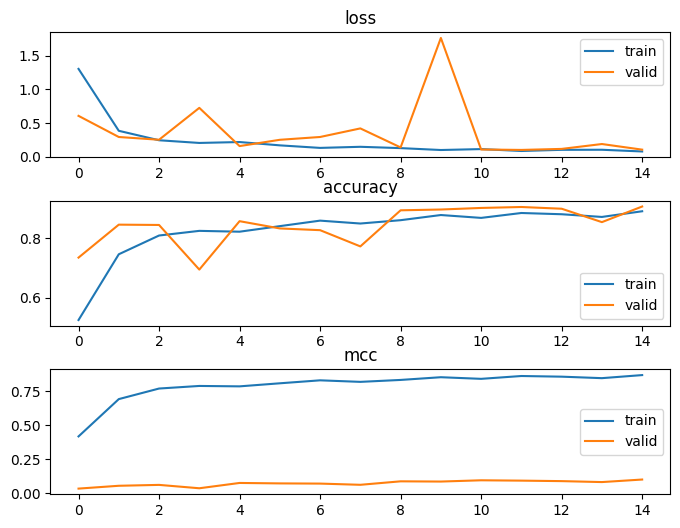

In [38]:
metric_names = ['loss', 'accuracy', 'mcc']
_, ax = plt.subplots(len(metric_names), 1, figsize=(8, 6))

for i, m in enumerate(metric_names):
    ax[i].set_title(m)
    ax[i].plot(train_metrics[:, i], label='train')
    ax[i].plot(valid_metrics[:, i], label='valid')
    ax[i].legend()

plt.subplots_adjust(wspace=0., hspace=0.35)
plt.show()

### Test Model performance

In [40]:
MODEL_PATH = 'trained_models/cls_focal/cls_model_15.pth'

classifier = PointNetClassHead(num_points=NUM_TEST_POINTS, num_global_feats=GLOBAL_FEATS, k=NUM_CLASSES).to(DEVICE)
classifier.load_state_dict(torch.load(MODEL_PATH))
classifier.eval();

#### Run test loop and get confusion matrix

In [41]:
num_test_batch = int(np.ceil(len(test_dataset)/BATCH_SIZE ))

with torch.no_grad():
    epoch_loss, \
    epoch_accuracy, \
    epoch_mcc, \
    total_test_targets, \
    total_test_preds = train_test(classifier, test_dataloader, 
                              num_test_batch, epoch=1, 
                              split='test')

	 [1: 0/90] test loss: 0.0649 accuracy: 0.8750 mcc: 0.0000
Epoch: 1 - test Loss: 18085.6716 - test Accuracy: 0.8330 - test MCC: 0.0650


In [42]:
from sklearn.metrics import confusion_matrix

test_confusion = pd.DataFrame(confusion_matrix(total_test_targets, total_test_preds),
                              columns=list(CATEGORIES.keys()),
                              index=list(CATEGORIES.keys()))

test_confusion

,Airplane,Bag,Cap,Car,Chair,Earphone,Guitar,Knife,Lamp,Laptop,Motorbike,Mug,Pistol,Rocket,Skateboard,Table
Airplane,302,0,0,2,13,0,0,3,13,7,1,0,0,0,0,0
Bag,0,0,2,2,2,0,0,0,6,0,0,2,0,0,0,0
Cap,0,0,6,0,2,0,0,0,2,0,0,0,0,0,0,1
Car,0,0,3,144,2,0,0,7,1,0,0,1,0,0,0,0
Chair,1,0,0,1,685,0,0,0,4,5,1,1,0,0,1,5
Earphone,0,0,1,0,0,3,1,0,9,0,0,0,0,0,0,0
Guitar,2,0,0,1,7,0,51,64,32,1,0,0,1,0,0,0
Knife,2,1,4,17,3,0,2,43,7,0,0,1,0,0,0,0
Lamp,2,1,2,0,6,3,0,10,240,4,0,5,1,0,1,11
Laptop,0,0,0,0,0,0,0,0,0,78,0,0,0,0,0,5


In [65]:
from random import randrange

torch.cuda.empty_cache() # release GPU memory

# get random sample from test data 
random_idx = randrange(len(test_sample_dataset))
points, seg = test_sample_dataset.__getitem__(random_idx)

# normalize points
norm_points = test_sample_dataset.normalize_points(points)

with torch.no_grad():
    norm_points = norm_points.unsqueeze(0).transpose(2, 1).to(DEVICE)
    targets = targets.squeeze().to(DEVICE)

    preds, crit_idxs, _ = classifier(norm_points)
    preds = torch.softmax(preds, dim=1)
    pred_choice = preds.squeeze().argmax() 

Inspect the results

In [66]:
pred_class = list(CATEGORIES.keys())[pred_choice.cpu().numpy()]
pred_prob = preds[0, pred_choice]
print(f'The predicted class is: {pred_class}, with probability: {pred_prob}')

The predicted class is: Lamp, with probability: 0.6074742078781128


Visualize the probabilities

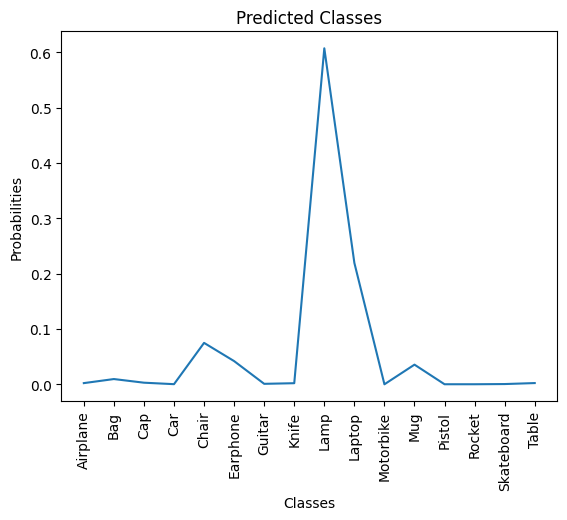

In [67]:
plt.plot(list(CATEGORIES.values()), preds.cpu().numpy()[0]);
plt.xticks(list(CATEGORIES.values()), list(CATEGORIES.keys()), rotation=90)
plt.title('Predicted Classes')
plt.xlabel('Classes')
plt.ylabel('Probabilities');

In [68]:
pcd = o3.geometry.PointCloud()
# pcd.points = o3.utility.Vector3dVector(norm_points[0, :, :].cpu().numpy().T)
pcd.points = o3.utility.Vector3dVector(points.cpu().numpy())
pcd.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

o3.visualization.draw_plotly([pcd])
# draw(pcd, point_size=5)

### Inspecting the critical sets

The critical sets are the points that make up the basic underlying structure of the point cloud. Now we will see how well the model has learned these.

See draw_plotly() source here: https://github.com/isl-org/Open3D/blob/master/python/open3d/visualization/draw_plotly.py

In [69]:
critical_points = points[crit_idxs.squeeze(), :]
critical_point_colors = read_pointnet_colors(seg.numpy())[crit_idxs.cpu().squeeze(), :]

pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(critical_points)
pcd.colors = o3.utility.Vector3dVector(critical_point_colors)

# o3.visualization.draw_plotly([pcd])
draw(pcd, point_size=5) # does not work in Colab

WebVisualizer(window_uid='window_1')